## KAN RL

In [1]:
!pip install moviepy~=1.0.3 gymnasium pykan~=0.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 56.1 MB/s eta 0:00:00
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110720 sha256=66842d722b74b568e675d4490c500ac20847c8ab43a1c7c666326d020f5c2b48
  Stored in directory: /root/.cache/pip/wheels/96/32/2d/e10123bd88fbfc02fed53cc18c80a171d3c87479ed845fa7c1
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1


## Models

100%|██████████| 26421880/26421880 [00:02<00:00, 9263263.61it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 138948.93it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:08<00:00, 505192.48it/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8395131.02it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

State shape: torch.Size([1, 8, 8])
Label: tensor(4)
Feedback shape: torch.Size([1, 8, 8])


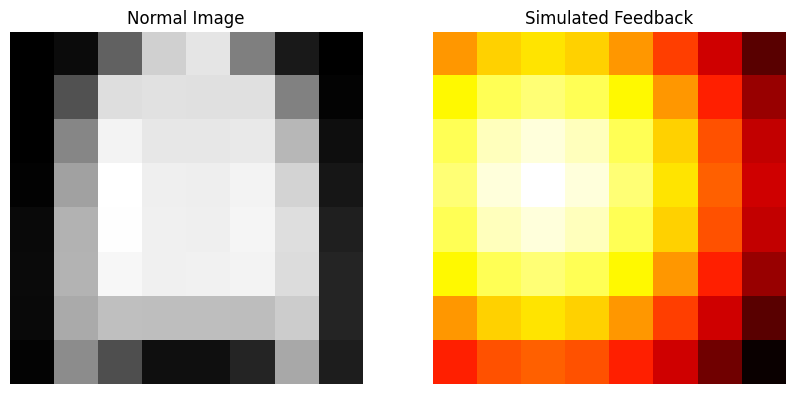

tensor(0.4404) tensor(1.)


In [2]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# https://github.com/Armour/pytorch-nn-practice/blob/master/utils/meanstd.py  for normalization values computation

class BenchmarkEnvironment:
    def __init__(self, dataset_name='MNIST', batch_size=128, image_size=(8, 8), feedback_sigma=5.0):
        self.batch_size = batch_size
        self.image_size = image_size
        self.feedback_sigma = feedback_sigma
        self.num_channels = 1  # Force single channel for all datasets

        if dataset_name == 'MNIST':
            # self.num_channels = 1
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])
            self.dataset = datasets.MNIST('./data', train=True, download=True, transform=self.transform)

        elif dataset_name == 'FashionMNIST':
            # self.num_channels = 1
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])
            self.dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=self.transform)

        elif dataset_name == 'CIFAR10':
            # self.num_channels = 3
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
                transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            ])
            self.dataset = datasets.CIFAR10('./data', train=True, download=True, transform=self.transform)

        elif dataset_name == 'CIFAR100':
            # self.num_channels = 3
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.50707516, 0.48654887, 0.44091784), (0.26733429, 0.25643846, 0.27615047)),
                transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            ])
            self.dataset = datasets.CIFAR100('./data', train=True, download=True, transform=self.transform)

        else:
            raise ValueError(f"Dataset {dataset_name} is not supported.")

        self.loader = DataLoader(self.dataset, batch_size=batch_size, shuffle=True)
        self.iterator = iter(self.loader)
        self.reset()

    def reset(self):
        try:
            self.current_batch = next(self.iterator)
        except StopIteration:
            self.iterator = iter(self.loader)
            self.current_batch = next(self.iterator)
        self.idx = 0

    def step(self):
        images, labels = self.current_batch
        if self.idx >= len(images):
            self.reset()
            return self.step()
        state = images[self.idx]
        label = labels[self.idx]
        feedback = self.generate_simulated_feedback(state.unsqueeze(0))
        self.idx += 1
        return state, label, feedback

    def generate_simulated_feedback(self, image_tensor):
        image_np = image_tensor.squeeze().numpy()

        # Normalize the image to [0, 1]
        image_np = (image_np - np.min(image_np)) / (np.max(image_np) - np.min(image_np))

        center_of_mass = np.array(np.unravel_index(np.argmax(image_np), image_np.shape[-2:]))

        x, y = np.meshgrid(np.arange(image_np.shape[-1]), np.arange(image_np.shape[-2]))
        gaussian_mask = np.exp(-((x - center_of_mass[1])**2 + (y - center_of_mass[0])**2) / (2 * self.feedback_sigma**2))

        feedback = gaussian_mask / np.max(gaussian_mask)
        return torch.tensor(feedback, dtype=torch.float32).view(1, *feedback.shape)


def plot_images(normal_image, feedback_image):
    # Convert tensors to numpy arrays
    normal_image_np = normal_image.squeeze().numpy()
    feedback_image_np = feedback_image.squeeze().numpy()

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot normal image
    axes[0].imshow(normal_image_np, cmap='gray')
    axes[0].set_title('Normal Image')
    axes[0].axis('off')

    # Plot feedback image
    axes[1].imshow(feedback_image_np, cmap='hot')  # Using 'hot' colormap to visualize feedback
    axes[1].set_title('Simulated Feedback')
    axes[1].axis('off')

    plt.show()

# Example usage:
if __name__ == "__main__":
    env = BenchmarkEnvironment(dataset_name='FashionMNIST', batch_size=128, feedback_sigma=5.0)
    state, label, feedback = env.step()
    print("State shape:", state.shape)
    print("Label:", label)
    print("Feedback shape:", feedback.shape)
    plot_images(state, feedback)
    print(feedback.min(), feedback.max())


In [3]:
# @title
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist
from torch.optim.lr_scheduler import ExponentialLR

class FSNet(nn.Module):
    def __init__(self, input_shape, num_filters, num_conv_layers=3, hidden_dim=128, distribution=None, tau=1.0):
        super(FSNet, self).__init__()

        self.distribution = distribution
        self.global_step = 0
        self.initial_tau = tau
        self.tau_decay = 0.96  # Exponential decay rate

        layers = []
        in_channels = input_shape[0]
        channels = []

        for i in range(num_conv_layers):
            num_filters *= 2
            channels.append(num_filters)

        for i in range(num_conv_layers):
            # For a convolutional layer to keep the input and output shapes the same: P = (K-1)/2 with S = 1
            layers.append(nn.Conv2d(in_channels=in_channels, out_channels=channels[i], kernel_size=3, padding=1, stride=1))
            layers.append(nn.ReLU())
            # Each MaxPool2d layer with kernel size 2 and stride 2 will halve the height and width of the feature maps.
            layers.append(nn.MaxPool2d(2, 2))
            in_channels = channels[i]

        layers.append(nn.Flatten())
        self.feature_extractor = nn.Sequential(*layers)

        # Dummy forward pass to determine the output size of the feature extractor
        dummy_input = torch.empty(1, *input_shape)
        n_features = self.feature_extractor(dummy_input).shape[1]
        # print(n_features)

        self.fc1 = nn.Linear(n_features, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(hidden_dim, n_features)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=-1)

        # Storage for probabilities and feedback costs
        self.probs_history = []
        self.feedback_cost_history = []


    def forward(self, x, feedback=None, epoch=0, n_epochs=None):
        x = x.view(-1, 1, input_shape[1], input_shape[2])
        features = self.feature_extractor(x)

        x = self.relu(self.fc1(features))
        probs_logits = self.relu(self.fc2(x))
        probs = self.sigmoid(probs_logits)

        # Apply the simulated feedback as a weight to the feature selection
        if feedback is None:
            feedback = probs # so that mse_loss becomes 0 if no feedback is fed
        else:
            pass

        # Use distribution as weight of the features
        if self.distribution == 'bernoulli':
            mask = torch.distributions.Bernoulli(logits=probs_logits)
            sample_probs = mask.sample()
        if self.distribution == 'gumbel_softmax':
            tau = self.initial_tau * (self.tau_decay ** epoch)
            mask = F.gumbel_softmax(logits=probs_logits, tau=tau, hard=False)
            sample_probs = mask
        if self.distribution == 'gaussian':
            mu = probs_logits  # or some transformation of probs_logits
            sigma = torch.ones_like(mu)  # Standard deviation
            gaussian_dist = torch.distributions.Normal(mu, sigma)
            sample_probs = gaussian_dist.rsample()  # Use rsample for the reparameterization trick
        if self.distribution == 'beta':
            alpha = F.softplus(probs_logits) + 1
            beta = F.softplus(probs_logits) + 1
            beta_dist = torch.distributions.Beta(alpha, beta)
            sample_probs = beta_dist.sample()
        if self.distribution == 'dirichlet':
            concentration = F.softplus(probs_logits) + 1  # Ensuring positive values
            dirichlet_dist = torch.distributions.Dirichlet(concentration)
            sample_probs = dirichlet_dist.sample()
        elif self.distribution == 'multinomial':
            logits = probs_logits  # Logits for the multinomial distribution
            mask = torch.distributions.Multinomial(logits=logits)
            sample_probs = mask.sample()
        elif self.distribution == 'laplace':
            loc = probs_logits  # Mean of the logistic distribution
            scale = torch.ones_like(loc)  # Scale parameter
            laplace_dist = torch.distributions.Laplace(loc, scale)
            sample_probs = laplace_dist.sample()
        elif self.distribution == 'cauchy':
            loc = probs_logits  # Mean of the logistic distribution
            scale = torch.ones_like(loc)  # Scale parameter
            cauchy_dist = torch.distributions.Cauchy(loc, scale)
            sample_probs = cauchy_dist.sample()
        elif self.distribution == 'uniform':
            low = torch.zeros_like(probs_logits)  # Lower bound
            high = torch.ones_like(probs_logits)  # Upper bound
            uniform_dist = torch.distributions.Uniform(low, high)
            sample_probs = uniform_dist.sample()            

        # print(sample_probs.shape)

        feedback_cost = F.mse_loss(probs, feedback)

        flat_zoom_X = features * sample_probs

        return flat_zoom_X, feedback_cost, probs


# Example usage:
input_shape = (1, 8, 8)  # Change this to the desired input shape
num_conv_layers = 2  # Specify the desired number of convolutional layers
num_filters = 4 # [2,4], [3,8]
model = FSNet(input_shape, num_filters, num_conv_layers, hidden_dim=128, distribution='uniform')
print(model)

# Test with an example input
example_input = torch.randn(*input_shape)

# print(flat_zoom_X, probs)
# print(flat_zoom_X.shape[1])
flat_zoom_X, feedback_cost, probs = model.forward(example_input)
print(flat_zoom_X.shape)

FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
torch.Size([1, 64])


In [4]:
# @title
from collections import deque
import os
import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from kan import KAN
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional, Callable, Union

class ReplayBuffer:
    def __init__(self, capacity, observation_dim):
        self.capacity = capacity
        self.observations = torch.zeros(capacity, observation_dim)
        self.actions = torch.zeros(capacity, 1, dtype=torch.int64)
        self.next_observations = torch.zeros(capacity, observation_dim)
        self.rewards = torch.zeros(capacity, 1)
        self.terminations = torch.zeros(capacity, 1, dtype=torch.int)
        self.cursor = 0

    def add(self, observation, action, next_observation, reward, termination):
        index = self.cursor % self.capacity
        self.observations[index] = observation
        self.actions[index] = action
        self.next_observations[index] = next_observation
        self.rewards[index] = reward
        self.terminations[index] = termination
        self.cursor += 1

    def sample(self, batch_size):
        idx = np.random.permutation(np.arange(len(self)))[:batch_size]
        return (
            self.observations[idx],
            self.actions[idx],
            self.next_observations[idx],
            self.rewards[idx],
            self.terminations[idx],
        )

    def __len__(self):
        return min(self.cursor, self.capacity)



def kan_train(
    net,
    target,
    data,
    optimizer,
    gamma=0.99,
    lamb=0.0,
    lamb_l1=1.0,
    lamb_entropy=2.0,
    lamb_coef=0.0,
    lamb_coefdiff=0.0,
    small_mag_threshold=1e-16,
    small_reg_factor=1.0,
    feedback_cost=None,
    feature_selection=False,
):
    

    def reg(acts_scale):
        def nonlinear(x, th=small_mag_threshold, factor=small_reg_factor):
            return (x < th) * x * factor + (x > th) * (x + (factor - 1) * th)

        reg_ = 0.0
        for i in range(len(acts_scale)):
            vec = acts_scale[i].reshape(
                -1,
            )

            p = vec / torch.sum(vec)
            l1 = torch.sum(nonlinear(vec))
            entropy = -torch.sum(p * torch.log2(p + 1e-4))
            reg_ += lamb_l1 * l1 + lamb_entropy * entropy  # both l1 and entropy

        # regularize coefficient to encourage spline to be zero
        for i in range(len(net.act_fun)):
            coeff_l1 = torch.sum(torch.mean(torch.abs(net.act_fun[i].coef), dim=1))
            coeff_diff_l1 = torch.sum(
                torch.mean(torch.abs(torch.diff(net.act_fun[i].coef)), dim=1)
            )
            reg_ += lamb_coef * coeff_l1 + lamb_coefdiff * coeff_diff_l1

        return reg_

    observations, actions, next_observations, rewards, terminations = data

    with torch.no_grad():
        next_q_values = net(next_observations.detach())
        next_actions = next_q_values.argmax(dim=1)
        next_q_values_target = target(next_observations.detach())
        target_max = next_q_values_target[range(len(next_q_values)), next_actions]
        td_target = rewards.detach().flatten() + gamma * target_max * (
            1 - terminations.detach().flatten()
        )


    old_val = net(observations.detach()).gather(1, actions.detach()).squeeze()
    criterion = nn.SmoothL1Loss()
    # criterion = nn.MSELoss()
    # loss = criterion(td_target, old_val)
    reg_ = reg(net.acts_scale)
    loss = criterion(td_target, old_val) + lamb * reg_

    # Combine the original cost function with the feedback loss
    if feature_selection == True:
        combined_loss = loss + 0.5 * feedback_cost.detach()
    # print(loss, feedback_cost.detach())
    else:
        combined_loss = loss

    optimizer.zero_grad()
    combined_loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(net.parameters(), 100)
    optimizer.step()

    return combined_loss.item()

def mlp_train(
    net,
    target,
    data,
    optimizer,
    gamma=0.99,
    feedback_cost=None,
    feature_selection=False,
):
    observations, actions, next_observations, rewards, terminations = data

    # Compute everything related to primary loss in a single block to retain the graph
    with torch.no_grad():
        next_q_values = net(next_observations.detach())
        next_actions = next_q_values.argmax(dim=1)
        next_q_values_target = target(next_observations.detach())
        target_max = next_q_values_target[range(len(next_q_values)), next_actions]
        td_target = rewards.detach().flatten() + gamma * target_max * (
            1 - terminations.detach().flatten()
        )

    old_val = net(observations.detach()).gather(1, actions.detach()).squeeze()
    criterion = nn.SmoothL1Loss()
    # criterion = nn.MSELoss()
    loss = criterion(td_target, old_val)

    # Combine the original cost function with the feedback loss
    if feature_selection == True:
      combined_loss = loss + 0.5 * feedback_cost.detach()
    # print(loss, feedback_cost.detach())
    else:
      combined_loss = loss

    optimizer.zero_grad()
    combined_loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(net.parameters(), 100)
    optimizer.step()

    return combined_loss.item()


def set_all_seeds(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(True)



2024-08-21 14:09:09.217002: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 14:09:09.217156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 14:09:09.371189: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# @title
import os
import time
import random
import shutil
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm

def kanRL(config):
      set_all_seeds(config["seed"])
      env = BenchmarkEnvironment(dataset_name='FashionMNIST', batch_size=config["batch_size"], feedback_sigma=5.0)    #MNISTEnvironment(config["batch_size"])
      results_dir = 'results'

      # Check if the directory exists before trying to delete it
      # if os.path.exists(results_dir) and os.path.isdir(results_dir):
      #     shutil.rmtree(results_dir)
      #     print(f"Directory '{results_dir}' has been deleted.")
      # else:
      #     print(f"Directory '{results_dir}' does not exist.")

      input_shape = (config['first_channel'], int(config['input_size']**0.5), int(config['input_size']**0.5))  # Change this to the desired input shape
      print(input_shape)
      agent = FSNet(input_shape, config['num_filters'], config['num_conv_layers'], config['hidden_dim'], distribution=config['distribution'], tau=config['initial_tau'])
      print(agent)

      if config["feature_selection"] == True:
          example_input = torch.randn(*input_shape)
          features, _, _ = agent(example_input)
          n_features = features.shape[1]
          print(n_features)
      else:
          n_features = config["input_size"]

      if config["method"] == "KAN":
          q_network = KAN(
              width=[n_features, config["width"], config["output_size"]],
              grid=config["grid"],
              k=3,
              bias_trainable=False,
              sp_trainable=False,
              sb_trainable=False,
          )
          target_network = KAN(
              width=[n_features, config["width"], config["output_size"]],
              grid=config["grid"],
              k=3,
              bias_trainable=False,
              sp_trainable=False,
              sb_trainable=False,
          )
          train = kan_train
      elif config["method"] == "MLP":
          q_network = nn.Sequential(
              nn.Linear(n_features, config["width"]),
              nn.ReLU(),
              nn.Linear(config["width"], config["output_size"]),
          )
          target_network = nn.Sequential(
              nn.Linear(n_features, config["width"]),
              nn.ReLU(),
              nn.Linear(config["width"], config["output_size"]),
          )
          train = mlp_train
      else:
          raise Exception(
              f"Method {config['method']} doesn't exist, choose between MLP and KAN."
          )

      target_network.load_state_dict(q_network.state_dict())

      run_name = f"{config['method']}_MNIST_{config['seed']}_{int(time.time())}"

      writer = SummaryWriter(f"runs/{run_name}")

      os.makedirs("results", exist_ok=True)
      with open(f"results/{run_name}.csv", "w") as f:
          f.write("epoch,accuracy\n")


      optimizer = optim.Adam(list(agent.parameters())+list(q_network.parameters()), lr = config["learning_rate"], weight_decay = config["weight_decay"])
      # Define learning rate scheduler
      scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=config['gamma'])

      writer.add_text(
          "hyperparameters",
          "|param|value|\n|-|-|\n%s"
          % ("\n".join([f"|{key}|{value}|" for key, value in config.items()])),
      )

      replay_buffer = ReplayBuffer(config["buffer_size"], n_features) # change here if the input size changes

      train_accuracies = []
      test_accuracies = []
      train_acc_stds = []
      test_acc_stds = []
      episode_lengths = []
      losses = []
      loss_stds = []
      probs_history = []
      feedback_cost_history = []

      # Training phase
      for epoch in tqdm(range(config["n_epochs"]), desc=f"{run_name}"):
          running_loss = 0.0
          correct = 0
          total = 0
          probs_batch_list = []
          feedback_cost_tot = 0

          for _ in range(len(env.loader)):
              state, label, feedback = env.step()
              feedback = feedback.view(-1, config['input_size'])

              if config["feature_selection"] == True:
                  flat_zoom_X, feedback_cost, probs = agent.forward(state, feedback, epoch, config["n_epochs"])
                  # Collect the probabilities and feedback costs
                  probs_batch_list.append(probs.detach().cpu().numpy())
                  feedback_cost_tot += feedback_cost.detach().cpu().numpy()
                  # Calculate regularization loss
                  state = flat_zoom_X
              else:
                  state = state.view(-1, config['input_size'])
                  probs_batch_list.append(torch.zeros((1, int(config['input_size']))))
                  probs = torch.zeros((1, int(config['input_size'])))
                  feedback_cost = torch.zeros(1)
                  feedback_cost_tot += torch.zeros(1)

              # Forward pass
              if epoch < config["warm_up_episodes"]:
                  action = torch.tensor([random.randint(0, 9)])
              else:
                  with torch.no_grad():
                      action = q_network(state).argmax(axis=-1).squeeze().item()

              reward = torch.tensor([1.0]) if action == label else torch.tensor([0.0])
              next_state, next_label, _ = env.step()
              if config["feature_selection"] == True:
                  next_state, _, _ = agent.forward(next_state)
              else:
                  next_state = next_state.view(-1, config['input_size'])

              replay_buffer.add(state, action, next_state, reward, torch.tensor([1]))

              if len(replay_buffer) > config["batch_size"]:
                  batch = replay_buffer.sample(config["batch_size"])
                  loss = train(
                      q_network,
                      target_network,
                      batch,
                      optimizer,
                      gamma=config["gamma"],
                      feedback_cost = feedback_cost,
                      feature_selection = config['feature_selection'],
                  )
                  running_loss += loss

              correct += (action == label).sum().item()
              total += 1

          scheduler.step()
          print()
          print('correct:', correct, 'total:', total)
          print('loss:', running_loss/total)
          train_accuracy = correct / total
          print(' Train accuracy: ', train_accuracy, '| ')
          train_accuracies.append(train_accuracy)
          losses.append(running_loss/total)

          # Aggregate probabilities by averaging across the batch
          avg_probs = np.mean(np.array(probs_batch_list), axis=0)
          probs_history.append(avg_probs)
          # Compute feedback cost
          feedback_cost_history.append(feedback_cost_tot / len(env.loader))

          if (
              epoch % 25 == 0
              and config["method"] == "KAN"
              and epoch < int(config["n_epochs"] * (1 / 2))
          ):
              q_network.update_grid_from_samples(replay_buffer.observations[: len(replay_buffer)])
              target_network.update_grid_from_samples(replay_buffer.observations[: len(replay_buffer)])

          if epoch % config["target_update"] == 0:
              target_network.load_state_dict(q_network.state_dict())


          correct = 0
          total = 0
          with torch.no_grad():
                  # transforms.Normalize((0.1307,), (0.3081,)) # MNIST
                  # transforms.Normalize((0.5,), (0.5,)) # FashionMNIST
                  # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), # CIFAR10
                  # transforms.Normalize((0.50707516, 0.48654887, 0.44091784), (0.26733429, 0.25643846, 0.27615047)), # CIFAR100
              for images, labels in DataLoader(datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.Compose([
                  transforms.Resize((int(config['input_size']**0.5), int(config['input_size']**0.5))),
                  transforms.ToTensor(),
                  transforms.Normalize((0.5,), (0.5,)), # FashionMNIST
                  transforms.Grayscale(num_output_channels=1)
              ])), batch_size=config["batch_size"]):
                  state = images.view(-1,config["input_size"])

                  if config["feature_selection"] == True:
                      flat_zoom_X, _, _ = agent(state)
                      state = flat_zoom_X

                  outputs = q_network(state)
                  _, predicted = torch.max(outputs.data, 1)
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()

          test_accuracy = correct / total
          print(' Test accuracy: ', test_accuracy)
          test_accuracies.append(test_accuracy)

          writer.add_scalar("Loss/train", running_loss / total, epoch)
          writer.add_scalar("Accuracy/train", train_accuracy, epoch)
          writer.add_scalar("Accuracy/test", test_accuracy, epoch)

          with open(f"results/{run_name}.csv", "a") as f:
              f.write(f"{epoch},{test_accuracy}\n")


      # Calculate standard deviations
      train_acc_stds = [np.std(train_accuracies[max(0, i-10):i+1]) for i in range(len(train_accuracies))]
      test_acc_stds = [np.std(test_accuracies[max(0, i-10):i+1]) for i in range(len(test_accuracies))]
      loss_stds = [np.std(losses[max(0, i-10):i+1]) for i in range(len(losses))]

      epochs = np.arange(len(train_accuracies))

      #### With uncertainty ########
      plt.figure(figsize=(12, 5))

      plt.subplot(1, 2, 1)
      plt.plot(epochs, train_accuracies, label='Train Accuracy')
      plt.fill_between(epochs, np.array(train_accuracies) - np.array(train_acc_stds), np.array(train_accuracies) + np.array(train_acc_stds), alpha=0.3)
      plt.plot(epochs, test_accuracies, label='Test Accuracy')
      plt.fill_between(epochs, np.array(test_accuracies) - np.array(test_acc_stds), np.array(test_accuracies) + np.array(test_acc_stds), alpha=0.3)
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.title('Accuracy over Time')

      plt.subplot(1, 2, 2)
      plt.plot(epochs, losses, label='Loss')
      plt.fill_between(epochs, np.array(losses) - np.array(loss_stds), np.array(losses) + np.array(loss_stds), alpha=0.3)
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.title('Loss over Time')

      plt.tight_layout()
      plt.show()


      ##### Without uncertainty ########
      plt.figure(figsize=(12, 5))

      plt.subplot(1, 2, 1)
      plt.plot(epochs, train_accuracies, label='Train Accuracy')
      plt.plot(epochs, test_accuracies, label='Test Accuracy')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.title('Accuracy over Time')

      plt.subplot(1, 2, 2)
      plt.plot(epochs, losses, label='Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.title('Loss over Time')

      plt.tight_layout()
      plt.show()

      # Print final accuracy with +/- error
      final_train_accuracy = train_accuracies[-1]
      final_train_acc_std = train_acc_stds[-1]
      final_test_accuracy = test_accuracies[-1]
      final_test_acc_std = test_acc_stds[-1]

      print(f"Final Train Accuracy: {final_train_accuracy:.2f} ± {final_train_acc_std:.2f}")
      print(f"Final Test Accuracy: {final_test_accuracy:.2f} ± {final_test_acc_std:.2f}")


      return q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent


# KAN width=8 grid=2

(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


KAN_MNIST_0_1724249360:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 47 total: 469
loss: 0.06577186656595548
 Train accuracy:  0.10021321961620469 | 


KAN_MNIST_0_1724249360:   1%|          | 1/100 [01:52<3:05:23, 112.36s/it]

 Test accuracy:  0.1583

correct: 40 total: 469
loss: 0.06121986808934446
 Train accuracy:  0.08528784648187633 | 


KAN_MNIST_0_1724249360:   2%|▏         | 2/100 [04:28<3:45:30, 138.07s/it]

 Test accuracy:  0.4655

correct: 219 total: 469
loss: 0.06269692854364035
 Train accuracy:  0.4669509594882729 | 


KAN_MNIST_0_1724249360:   3%|▎         | 3/100 [07:24<4:11:09, 155.35s/it]

 Test accuracy:  0.496

correct: 222 total: 469
loss: 0.06937598555422286
 Train accuracy:  0.47334754797441364 | 


KAN_MNIST_0_1724249360:   4%|▍         | 4/100 [10:20<4:21:42, 163.57s/it]

 Test accuracy:  0.4939

correct: 235 total: 469
loss: 0.07354336174756987
 Train accuracy:  0.5010660980810234 | 


KAN_MNIST_0_1724249360:   5%|▌         | 5/100 [13:17<4:26:52, 168.55s/it]

 Test accuracy:  0.5132

correct: 243 total: 469
loss: 0.07680657906318779
 Train accuracy:  0.5181236673773987 | 


KAN_MNIST_0_1724249360:   6%|▌         | 6/100 [16:15<4:28:58, 171.69s/it]

 Test accuracy:  0.5239

correct: 265 total: 469
loss: 0.07977685370424917
 Train accuracy:  0.5650319829424307 | 


KAN_MNIST_0_1724249360:   7%|▋         | 7/100 [19:13<4:29:08, 173.64s/it]

 Test accuracy:  0.5412

correct: 247 total: 469
loss: 0.08343120854991332
 Train accuracy:  0.5266524520255863 | 


KAN_MNIST_0_1724249360:   8%|▊         | 8/100 [22:12<4:28:51, 175.34s/it]

 Test accuracy:  0.5444

correct: 254 total: 469
loss: 0.08719370037571454
 Train accuracy:  0.5415778251599147 | 


KAN_MNIST_0_1724249360:   9%|▉         | 9/100 [25:12<4:28:02, 176.73s/it]

 Test accuracy:  0.5583

correct: 264 total: 469
loss: 0.08857447644477205
 Train accuracy:  0.5628997867803838 | 


KAN_MNIST_0_1724249360:  10%|█         | 10/100 [28:12<4:26:42, 177.80s/it]

 Test accuracy:  0.5672

correct: 266 total: 469
loss: 0.09078827784704502
 Train accuracy:  0.5671641791044776 | 


KAN_MNIST_0_1724249360:  11%|█         | 11/100 [31:12<4:25:02, 178.68s/it]

 Test accuracy:  0.5763

correct: 261 total: 469
loss: 0.09288633730747044
 Train accuracy:  0.5565031982942431 | 


KAN_MNIST_0_1724249360:  12%|█▏        | 12/100 [34:14<4:23:21, 179.56s/it]

 Test accuracy:  0.5781

correct: 273 total: 469
loss: 0.09416023003203529
 Train accuracy:  0.582089552238806 | 


KAN_MNIST_0_1724249360:  13%|█▎        | 13/100 [37:15<4:21:04, 180.05s/it]

 Test accuracy:  0.5926

correct: 277 total: 469
loss: 0.09582843718879512
 Train accuracy:  0.5906183368869936 | 


KAN_MNIST_0_1724249360:  14%|█▍        | 14/100 [40:16<4:18:28, 180.33s/it]

 Test accuracy:  0.5892

correct: 262 total: 469
loss: 0.095357354785969
 Train accuracy:  0.55863539445629 | 


KAN_MNIST_0_1724249360:  15%|█▌        | 15/100 [43:18<4:16:07, 180.80s/it]

 Test accuracy:  0.6017

correct: 295 total: 469
loss: 0.0974510367205148
 Train accuracy:  0.6289978678038379 | 


KAN_MNIST_0_1724249360:  16%|█▌        | 16/100 [46:21<4:13:55, 181.38s/it]

 Test accuracy:  0.6161

correct: 293 total: 469
loss: 0.09736204017072853
 Train accuracy:  0.6247334754797441 | 


KAN_MNIST_0_1724249360:  17%|█▋        | 17/100 [49:23<4:11:07, 181.54s/it]

 Test accuracy:  0.5986

correct: 308 total: 469
loss: 0.09811229611447117
 Train accuracy:  0.6567164179104478 | 


KAN_MNIST_0_1724249360:  18%|█▊        | 18/100 [52:26<4:08:45, 182.02s/it]

 Test accuracy:  0.6099

correct: 297 total: 469
loss: 0.0991495092953446
 Train accuracy:  0.6332622601279317 | 


KAN_MNIST_0_1724249360:  19%|█▉        | 19/100 [55:28<4:05:54, 182.15s/it]

 Test accuracy:  0.6184

correct: 287 total: 469
loss: 0.0992218379749418
 Train accuracy:  0.6119402985074627 | 


KAN_MNIST_0_1724249360:  20%|██        | 20/100 [58:31<4:03:10, 182.38s/it]

 Test accuracy:  0.6045

correct: 294 total: 469
loss: 0.10018745431704308
 Train accuracy:  0.6268656716417911 | 


KAN_MNIST_0_1724249360:  21%|██        | 21/100 [1:01:34<4:00:14, 182.46s/it]

 Test accuracy:  0.618

correct: 299 total: 469
loss: 0.10117662033991519
 Train accuracy:  0.6375266524520256 | 


KAN_MNIST_0_1724249360:  22%|██▏       | 22/100 [1:04:38<3:57:38, 182.81s/it]

 Test accuracy:  0.6316

correct: 298 total: 469
loss: 0.10210240230377295
 Train accuracy:  0.6353944562899787 | 


KAN_MNIST_0_1724249360:  23%|██▎       | 23/100 [1:07:41<3:54:41, 182.88s/it]

 Test accuracy:  0.6214

correct: 297 total: 469
loss: 0.10127380849328885
 Train accuracy:  0.6332622601279317 | 


KAN_MNIST_0_1724249360:  24%|██▍       | 24/100 [1:10:43<3:51:37, 182.86s/it]

 Test accuracy:  0.6352

correct: 293 total: 469
loss: 0.1036774536122137
 Train accuracy:  0.6247334754797441 | 


KAN_MNIST_0_1724249360:  25%|██▌       | 25/100 [1:13:46<3:48:25, 182.74s/it]

 Test accuracy:  0.6285

correct: 287 total: 469
loss: 0.10469638926388104
 Train accuracy:  0.6119402985074627 | 


KAN_MNIST_0_1724249360:  26%|██▌       | 26/100 [1:17:15<3:55:09, 190.67s/it]

 Test accuracy:  0.6372

correct: 288 total: 469
loss: 0.11038495328571242
 Train accuracy:  0.6140724946695096 | 


KAN_MNIST_0_1724249360:  27%|██▋       | 27/100 [1:20:18<3:49:06, 188.30s/it]

 Test accuracy:  0.6521

correct: 301 total: 469
loss: 0.10987035507586465
 Train accuracy:  0.6417910447761194 | 


KAN_MNIST_0_1724249360:  28%|██▊       | 28/100 [1:23:20<3:43:37, 186.35s/it]

 Test accuracy:  0.6615

correct: 328 total: 469
loss: 0.10887107842448931
 Train accuracy:  0.6993603411513859 | 


KAN_MNIST_0_1724249360:  29%|██▉       | 29/100 [1:26:22<3:39:09, 185.20s/it]

 Test accuracy:  0.6552

correct: 328 total: 469
loss: 0.10983674056621502
 Train accuracy:  0.6993603411513859 | 


KAN_MNIST_0_1724249360:  30%|███       | 30/100 [1:29:31<3:37:24, 186.35s/it]

 Test accuracy:  0.653

correct: 308 total: 469
loss: 0.10955044206208003
 Train accuracy:  0.6567164179104478 | 


KAN_MNIST_0_1724249360:  31%|███       | 31/100 [1:32:41<3:35:22, 187.28s/it]

 Test accuracy:  0.6581

correct: 318 total: 469
loss: 0.10969376716532432
 Train accuracy:  0.6780383795309168 | 


KAN_MNIST_0_1724249360:  32%|███▏      | 32/100 [1:35:50<3:33:04, 188.00s/it]

 Test accuracy:  0.6613

correct: 298 total: 469
loss: 0.10995603591076601
 Train accuracy:  0.6353944562899787 | 


KAN_MNIST_0_1724249360:  33%|███▎      | 33/100 [1:38:59<3:30:02, 188.10s/it]

 Test accuracy:  0.6719

correct: 328 total: 469
loss: 0.10980152635813267
 Train accuracy:  0.6993603411513859 | 


KAN_MNIST_0_1724249360:  34%|███▍      | 34/100 [1:42:07<3:27:02, 188.22s/it]

 Test accuracy:  0.6729

correct: 309 total: 469
loss: 0.11120567030744004
 Train accuracy:  0.6588486140724946 | 


KAN_MNIST_0_1724249360:  35%|███▌      | 35/100 [1:45:15<3:23:57, 188.27s/it]

 Test accuracy:  0.6794

correct: 305 total: 469
loss: 0.11023877100395496
 Train accuracy:  0.650319829424307 | 


KAN_MNIST_0_1724249360:  36%|███▌      | 36/100 [1:48:24<3:20:52, 188.31s/it]

 Test accuracy:  0.6821

correct: 332 total: 469
loss: 0.11005165985525289
 Train accuracy:  0.7078891257995735 | 


KAN_MNIST_0_1724249360:  37%|███▋      | 37/100 [1:51:35<3:18:29, 189.04s/it]

 Test accuracy:  0.6731

correct: 310 total: 469
loss: 0.11075487588323764
 Train accuracy:  0.6609808102345416 | 


KAN_MNIST_0_1724249360:  38%|███▊      | 38/100 [1:54:45<3:15:40, 189.36s/it]

 Test accuracy:  0.6773

correct: 310 total: 469
loss: 0.10952579997368712
 Train accuracy:  0.6609808102345416 | 


KAN_MNIST_0_1724249360:  39%|███▉      | 39/100 [1:57:54<3:12:36, 189.45s/it]

 Test accuracy:  0.6764

correct: 325 total: 469
loss: 0.11013337788678436
 Train accuracy:  0.6929637526652452 | 


KAN_MNIST_0_1724249360:  40%|████      | 40/100 [2:01:04<3:09:27, 189.47s/it]

 Test accuracy:  0.6873

correct: 324 total: 469
loss: 0.110612100121309
 Train accuracy:  0.6908315565031983 | 


KAN_MNIST_0_1724249360:  41%|████      | 41/100 [2:04:13<3:06:15, 189.42s/it]

 Test accuracy:  0.6822

correct: 342 total: 469
loss: 0.11057403205490823
 Train accuracy:  0.7292110874200426 | 


KAN_MNIST_0_1724249360:  42%|████▏     | 42/100 [2:07:22<3:03:02, 189.35s/it]

 Test accuracy:  0.6799

correct: 332 total: 469
loss: 0.11080973946463579
 Train accuracy:  0.7078891257995735 | 


KAN_MNIST_0_1724249360:  43%|████▎     | 43/100 [2:10:32<2:59:57, 189.44s/it]

 Test accuracy:  0.6716

correct: 320 total: 469
loss: 0.11113399729482147
 Train accuracy:  0.6823027718550106 | 


KAN_MNIST_0_1724249360:  44%|████▍     | 44/100 [2:13:41<2:56:46, 189.41s/it]

 Test accuracy:  0.6914

correct: 307 total: 469
loss: 0.11164755007224296
 Train accuracy:  0.6545842217484008 | 


KAN_MNIST_0_1724249360:  45%|████▌     | 45/100 [2:16:51<2:53:40, 189.47s/it]

 Test accuracy:  0.6855

correct: 327 total: 469
loss: 0.1120939947076952
 Train accuracy:  0.697228144989339 | 


KAN_MNIST_0_1724249360:  46%|████▌     | 46/100 [2:20:00<2:50:22, 189.31s/it]

 Test accuracy:  0.6831

correct: 318 total: 469
loss: 0.11121445339816466
 Train accuracy:  0.6780383795309168 | 


KAN_MNIST_0_1724249360:  47%|████▋     | 47/100 [2:23:09<2:47:13, 189.31s/it]

 Test accuracy:  0.673

correct: 321 total: 469
loss: 0.11287794996108581
 Train accuracy:  0.6844349680170576 | 


KAN_MNIST_0_1724249360:  48%|████▊     | 48/100 [2:26:20<2:44:28, 189.79s/it]

 Test accuracy:  0.6815

correct: 328 total: 469
loss: 0.11250646364714291
 Train accuracy:  0.6993603411513859 | 


KAN_MNIST_0_1724249360:  49%|████▉     | 49/100 [2:29:30<2:41:15, 189.72s/it]

 Test accuracy:  0.6875

correct: 327 total: 469
loss: 0.11235024584635997
 Train accuracy:  0.697228144989339 | 


KAN_MNIST_0_1724249360:  50%|█████     | 50/100 [2:32:39<2:38:00, 189.61s/it]

 Test accuracy:  0.6788

correct: 327 total: 469
loss: 0.11367467199879161
 Train accuracy:  0.697228144989339 | 


KAN_MNIST_0_1724249360:  51%|█████     | 51/100 [2:35:48<2:34:42, 189.44s/it]

 Test accuracy:  0.6873

correct: 339 total: 469
loss: 0.11218422657645333
 Train accuracy:  0.7228144989339019 | 


KAN_MNIST_0_1724249360:  52%|█████▏    | 52/100 [2:38:59<2:31:49, 189.79s/it]

 Test accuracy:  0.6891

correct: 328 total: 469
loss: 0.11261404383538375
 Train accuracy:  0.6993603411513859 | 


KAN_MNIST_0_1724249360:  53%|█████▎    | 53/100 [2:42:09<2:28:53, 190.08s/it]

 Test accuracy:  0.6846

correct: 320 total: 469
loss: 0.11213878192690643
 Train accuracy:  0.6823027718550106 | 


KAN_MNIST_0_1724249360:  54%|█████▍    | 54/100 [2:45:20<2:25:52, 190.27s/it]

 Test accuracy:  0.6687

correct: 330 total: 469
loss: 0.11282797682005713
 Train accuracy:  0.7036247334754797 | 


KAN_MNIST_0_1724249360:  55%|█████▌    | 55/100 [2:48:30<2:22:41, 190.25s/it]

 Test accuracy:  0.6807

correct: 319 total: 469
loss: 0.11250497311798495
 Train accuracy:  0.6801705756929638 | 


KAN_MNIST_0_1724249360:  56%|█████▌    | 56/100 [2:51:41<2:19:31, 190.27s/it]

 Test accuracy:  0.6845

correct: 310 total: 469
loss: 0.11300053490377439
 Train accuracy:  0.6609808102345416 | 


KAN_MNIST_0_1724249360:  57%|█████▋    | 57/100 [2:54:51<2:16:26, 190.38s/it]

 Test accuracy:  0.6918

correct: 323 total: 469
loss: 0.11304148302467139
 Train accuracy:  0.6886993603411514 | 


KAN_MNIST_0_1724249360:  58%|█████▊    | 58/100 [2:58:03<2:13:28, 190.68s/it]

 Test accuracy:  0.6957

correct: 318 total: 469
loss: 0.11370223503250049
 Train accuracy:  0.6780383795309168 | 


KAN_MNIST_0_1724249360:  59%|█████▉    | 59/100 [3:01:14<2:10:23, 190.81s/it]

 Test accuracy:  0.6839

correct: 321 total: 469
loss: 0.11399048828938876
 Train accuracy:  0.6844349680170576 | 


KAN_MNIST_0_1724249360:  60%|██████    | 60/100 [3:04:24<2:07:03, 190.60s/it]

 Test accuracy:  0.6884

correct: 334 total: 469
loss: 0.11340207581136272
 Train accuracy:  0.7121535181236673 | 


KAN_MNIST_0_1724249360:  61%|██████    | 61/100 [3:07:34<2:03:52, 190.57s/it]

 Test accuracy:  0.6889

correct: 327 total: 469
loss: 0.11379950090067219
 Train accuracy:  0.697228144989339 | 


KAN_MNIST_0_1724249360:  62%|██████▏   | 62/100 [3:10:46<2:00:56, 190.95s/it]

 Test accuracy:  0.689

correct: 326 total: 469
loss: 0.11331973900037534
 Train accuracy:  0.6950959488272921 | 


KAN_MNIST_0_1724249360:  63%|██████▎   | 63/100 [3:13:57<1:57:39, 190.81s/it]

 Test accuracy:  0.6951

correct: 337 total: 469
loss: 0.11381721792063479
 Train accuracy:  0.7185501066098081 | 


KAN_MNIST_0_1724249360:  64%|██████▍   | 64/100 [3:17:09<1:54:41, 191.16s/it]

 Test accuracy:  0.6857

correct: 331 total: 469
loss: 0.11360603909312027
 Train accuracy:  0.7057569296375267 | 


KAN_MNIST_0_1724249360:  65%|██████▌   | 65/100 [3:20:21<1:51:40, 191.46s/it]

 Test accuracy:  0.6934

correct: 339 total: 469
loss: 0.11333684044987408
 Train accuracy:  0.7228144989339019 | 


KAN_MNIST_0_1724249360:  66%|██████▌   | 66/100 [3:23:31<1:48:19, 191.15s/it]

 Test accuracy:  0.6907

correct: 325 total: 469
loss: 0.11380615812946739
 Train accuracy:  0.6929637526652452 | 


KAN_MNIST_0_1724249360:  67%|██████▋   | 67/100 [3:26:43<1:45:10, 191.22s/it]

 Test accuracy:  0.703

correct: 329 total: 469
loss: 0.11360440752717224
 Train accuracy:  0.7014925373134329 | 


KAN_MNIST_0_1724249360:  68%|██████▊   | 68/100 [3:29:53<1:41:48, 190.88s/it]

 Test accuracy:  0.6899

correct: 320 total: 469
loss: 0.11394801824840146
 Train accuracy:  0.6823027718550106 | 


KAN_MNIST_0_1724249360:  69%|██████▉   | 69/100 [3:33:04<1:38:44, 191.10s/it]

 Test accuracy:  0.6958

correct: 331 total: 469
loss: 0.11512594311031452
 Train accuracy:  0.7057569296375267 | 


KAN_MNIST_0_1724249360:  70%|███████   | 70/100 [3:36:16<1:35:36, 191.22s/it]

 Test accuracy:  0.6976

correct: 311 total: 469
loss: 0.11381423398693487
 Train accuracy:  0.6631130063965884 | 


KAN_MNIST_0_1724249360:  71%|███████   | 71/100 [3:39:26<1:32:15, 190.89s/it]

 Test accuracy:  0.6863

correct: 317 total: 469
loss: 0.11510921760535697
 Train accuracy:  0.67590618336887 | 


KAN_MNIST_0_1724249360:  72%|███████▏  | 72/100 [3:42:36<1:28:57, 190.62s/it]

 Test accuracy:  0.7032

correct: 334 total: 469
loss: 0.11425864523344202
 Train accuracy:  0.7121535181236673 | 


KAN_MNIST_0_1724249360:  73%|███████▎  | 73/100 [3:45:46<1:25:42, 190.45s/it]

 Test accuracy:  0.6882

correct: 307 total: 469
loss: 0.11472056132516881
 Train accuracy:  0.6545842217484008 | 


KAN_MNIST_0_1724249360:  74%|███████▍  | 74/100 [3:48:57<1:22:35, 190.60s/it]

 Test accuracy:  0.6921

correct: 323 total: 469
loss: 0.11536259612422
 Train accuracy:  0.6886993603411514 | 


KAN_MNIST_0_1724249360:  75%|███████▌  | 75/100 [3:52:08<1:19:28, 190.75s/it]

 Test accuracy:  0.6952

correct: 329 total: 469
loss: 0.11462261272010518
 Train accuracy:  0.7014925373134329 | 


KAN_MNIST_0_1724249360:  76%|███████▌  | 76/100 [3:55:18<1:16:15, 190.64s/it]

 Test accuracy:  0.7035

correct: 315 total: 469
loss: 0.11464209379608443
 Train accuracy:  0.6716417910447762 | 


KAN_MNIST_0_1724249360:  77%|███████▋  | 77/100 [3:58:29<1:13:06, 190.72s/it]

 Test accuracy:  0.6924

correct: 323 total: 469
loss: 0.11473530086118784
 Train accuracy:  0.6886993603411514 | 


KAN_MNIST_0_1724249360:  78%|███████▊  | 78/100 [4:01:41<1:09:59, 190.89s/it]

 Test accuracy:  0.6998

correct: 354 total: 469
loss: 0.1137827446084541
 Train accuracy:  0.7547974413646056 | 


KAN_MNIST_0_1724249360:  79%|███████▉  | 79/100 [4:04:52<1:06:48, 190.88s/it]

 Test accuracy:  0.6988

correct: 333 total: 469
loss: 0.11364398415345373
 Train accuracy:  0.7100213219616205 | 


KAN_MNIST_0_1724249360:  80%|████████  | 80/100 [4:08:03<1:03:41, 191.07s/it]

 Test accuracy:  0.7013

correct: 330 total: 469
loss: 0.11421791497451156
 Train accuracy:  0.7036247334754797 | 


KAN_MNIST_0_1724249360:  81%|████████  | 81/100 [4:11:14<1:00:31, 191.15s/it]

 Test accuracy:  0.7017

correct: 319 total: 469
loss: 0.11464461420517741
 Train accuracy:  0.6801705756929638 | 


KAN_MNIST_0_1724249360:  82%|████████▏ | 82/100 [4:14:25<57:18, 191.02s/it]  

 Test accuracy:  0.7035

correct: 335 total: 469
loss: 0.11499176759010693
 Train accuracy:  0.7142857142857143 | 


KAN_MNIST_0_1724249360:  83%|████████▎ | 83/100 [4:17:36<54:08, 191.09s/it]

 Test accuracy:  0.6971

correct: 334 total: 469
loss: 0.11433765995921864
 Train accuracy:  0.7121535181236673 | 


KAN_MNIST_0_1724249360:  84%|████████▍ | 84/100 [4:20:48<50:59, 191.20s/it]

 Test accuracy:  0.6923

correct: 322 total: 469
loss: 0.11453250099791647
 Train accuracy:  0.6865671641791045 | 


KAN_MNIST_0_1724249360:  85%|████████▌ | 85/100 [4:24:00<47:51, 191.42s/it]

 Test accuracy:  0.7052

correct: 343 total: 469
loss: 0.11519298526142706
 Train accuracy:  0.7313432835820896 | 


KAN_MNIST_0_1724249360:  86%|████████▌ | 86/100 [4:27:10<44:36, 191.18s/it]

 Test accuracy:  0.7029

correct: 338 total: 469
loss: 0.11475491032862206
 Train accuracy:  0.720682302771855 | 


KAN_MNIST_0_1724249360:  87%|████████▋ | 87/100 [4:30:21<41:24, 191.11s/it]

 Test accuracy:  0.7028

correct: 330 total: 469
loss: 0.1145845674343709
 Train accuracy:  0.7036247334754797 | 


KAN_MNIST_0_1724249360:  88%|████████▊ | 88/100 [4:33:32<38:12, 191.06s/it]

 Test accuracy:  0.7

correct: 343 total: 469
loss: 0.11521075912185315
 Train accuracy:  0.7313432835820896 | 


KAN_MNIST_0_1724249360:  89%|████████▉ | 89/100 [4:36:43<35:01, 191.03s/it]

 Test accuracy:  0.7

correct: 333 total: 469
loss: 0.11540882279877977
 Train accuracy:  0.7100213219616205 | 


KAN_MNIST_0_1724249360:  90%|█████████ | 90/100 [4:39:56<31:57, 191.71s/it]

 Test accuracy:  0.6977

correct: 328 total: 469
loss: 0.11538466766699036
 Train accuracy:  0.6993603411513859 | 


KAN_MNIST_0_1724249360:  91%|█████████ | 91/100 [4:43:08<28:45, 191.73s/it]

 Test accuracy:  0.706

correct: 341 total: 469
loss: 0.11460188244070325
 Train accuracy:  0.7270788912579957 | 


KAN_MNIST_0_1724249360:  92%|█████████▏| 92/100 [4:46:20<25:33, 191.65s/it]

 Test accuracy:  0.7019

correct: 322 total: 469
loss: 0.1153988979740946
 Train accuracy:  0.6865671641791045 | 


KAN_MNIST_0_1724249360:  93%|█████████▎| 93/100 [4:49:31<22:20, 191.55s/it]

 Test accuracy:  0.6966

correct: 338 total: 469
loss: 0.11544252727141004
 Train accuracy:  0.720682302771855 | 


KAN_MNIST_0_1724249360:  94%|█████████▍| 94/100 [4:52:43<19:10, 191.67s/it]

 Test accuracy:  0.7036

correct: 329 total: 469
loss: 0.11491766098592836
 Train accuracy:  0.7014925373134329 | 


KAN_MNIST_0_1724249360:  95%|█████████▌| 95/100 [4:55:54<15:56, 191.36s/it]

 Test accuracy:  0.7006

correct: 322 total: 469
loss: 0.11524699946075107
 Train accuracy:  0.6865671641791045 | 


KAN_MNIST_0_1724249360:  96%|█████████▌| 96/100 [4:59:05<12:45, 191.29s/it]

 Test accuracy:  0.699

correct: 343 total: 469
loss: 0.1146673909318981
 Train accuracy:  0.7313432835820896 | 


KAN_MNIST_0_1724249360:  97%|█████████▋| 97/100 [5:02:16<09:34, 191.36s/it]

 Test accuracy:  0.7069

correct: 331 total: 469
loss: 0.11521851482676036
 Train accuracy:  0.7057569296375267 | 


KAN_MNIST_0_1724249360:  98%|█████████▊| 98/100 [5:05:27<06:22, 191.20s/it]

 Test accuracy:  0.7018

correct: 341 total: 469
loss: 0.11461820118208683
 Train accuracy:  0.7270788912579957 | 


KAN_MNIST_0_1724249360:  99%|█████████▉| 99/100 [5:08:40<03:11, 191.74s/it]

 Test accuracy:  0.7005

correct: 339 total: 469
loss: 0.11510189773558553
 Train accuracy:  0.7228144989339019 | 


KAN_MNIST_0_1724249360: 100%|██████████| 100/100 [5:11:51<00:00, 187.11s/it]

 Test accuracy:  0.7103


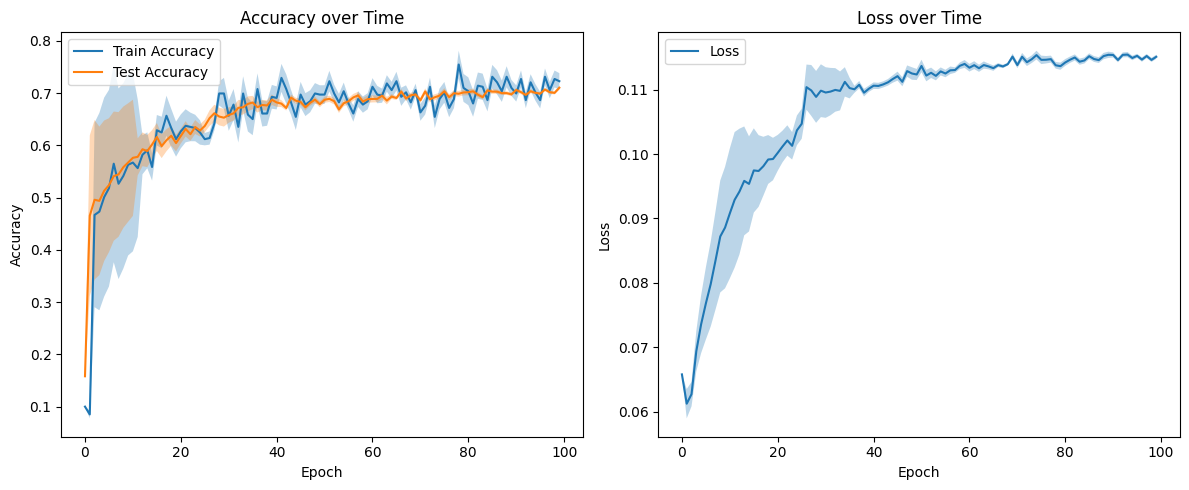

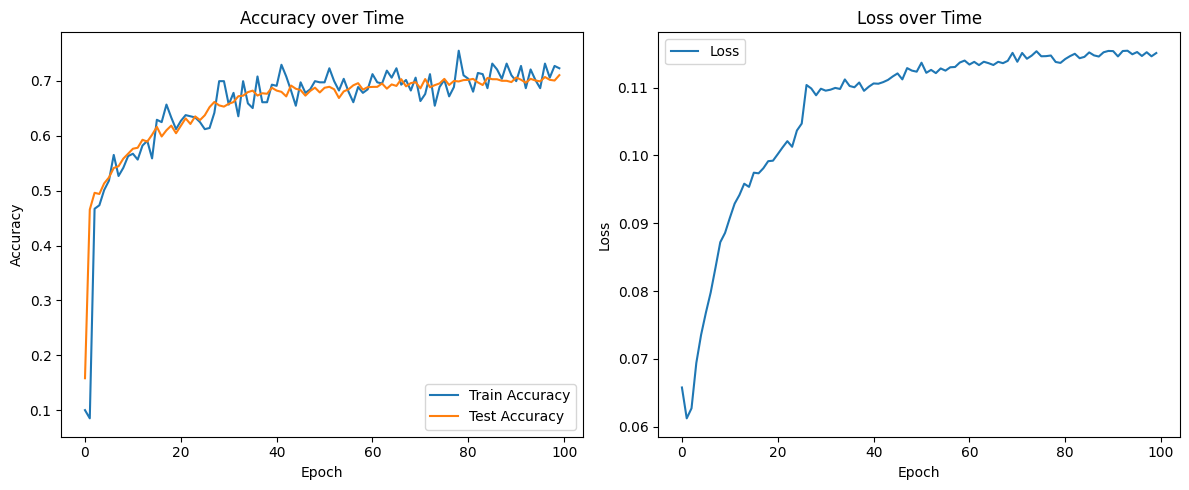

Final Train Accuracy: 0.72 ± 0.02
Final Test Accuracy: 0.71 ± 0.00


In [6]:

config = {
    "batch_size": 128,
    "n_epochs": 100,
    "gamma": 0.99,
    "learning_rate": 1e-3, # 0.0005
    "weight_decay": 1e-4,
    "width": 8,
    "grid": 2,
    "method": "KAN",  # "MLP", "KAN"
    "seed": 0,
    "input_size": 8 * 8, # number of features
    "output_size": 10, # number of classes
    "buffer_size": 100000,
    "target_update": 10,
    "warm_up_episodes": 2,
    "num_filters": 4,
    "num_conv_layers": 2,
    "first_channel": 1, # (1,8,8)
    "hidden_dim": 128,
    "feature_selection": True,
    "distribution": "beta", # bernoulli, categorical, gumbel_softmax, gaussian, beta, dirichlet
    "initial_tau": 1.0, # positive float value

}

q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent = kanRL(config)

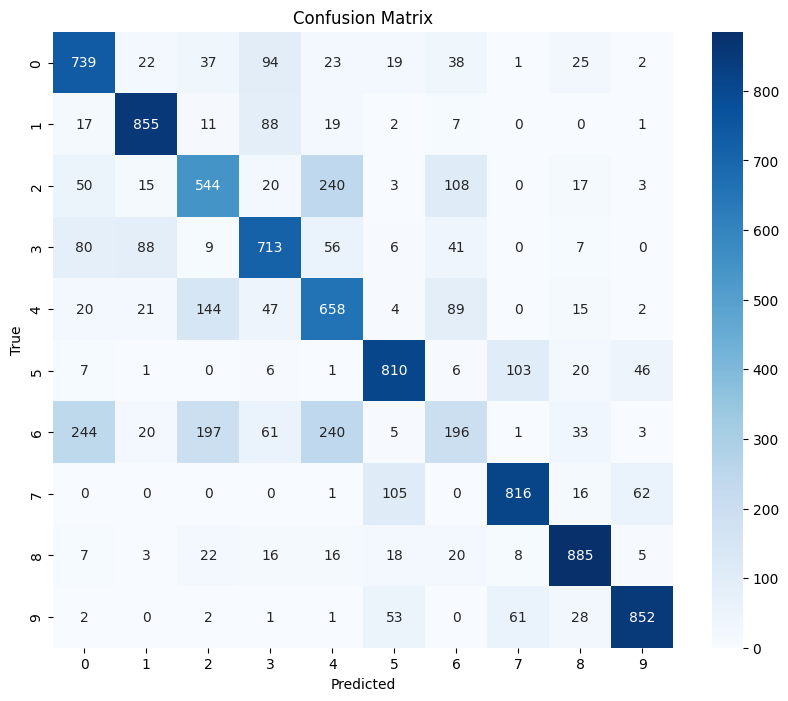

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []  # Ground truth labels
y_pred = []  # Model predictions

# Assuming `test_loader` is your DataLoader for test set
with torch.no_grad():
        # transforms.Normalize((0.1307,), (0.3081,)) # MNIST
        # transforms.Normalize((0.5,), (0.5,)) # FashionMNIST
        # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), # CIFAR10
        # transforms.Normalize((0.50707516, 0.48654887, 0.44091784), (0.26733429, 0.25643846, 0.27615047)), # CIFAR100
    for images, labels in DataLoader(datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.Compose([
        transforms.Resize((int(config['input_size']**0.5), int(config['input_size']**0.5))),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)), # FashionMNIST
        transforms.Grayscale(num_output_channels=1)
    ])), batch_size=config["batch_size"]):
        state = images.view(-1,config["input_size"])
        if config["feature_selection"] == True:
            flat_zoom_X, _, _ = agent(state)
            state = flat_zoom_X
        outputs = q_network(state)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels)
        y_pred.extend(predicted)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [8]:
import sklearn
print(sklearn.metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.74      0.68      1000
           1       0.83      0.85      0.84      1000
           2       0.56      0.54      0.55      1000
           3       0.68      0.71      0.70      1000
           4       0.52      0.66      0.58      1000
           5       0.79      0.81      0.80      1000
           6       0.39      0.20      0.26      1000
           7       0.82      0.82      0.82      1000
           8       0.85      0.89      0.87      1000
           9       0.87      0.85      0.86      1000

    accuracy                           0.71     10000
   macro avg       0.70      0.71      0.70     10000
weighted avg       0.70      0.71      0.70     10000



In [9]:
import gc
gc.collect()

0